In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [32]:

try:
    data = pd.read_csv(r'C:\Users\hp\Documents\elevo internship\walmart sales forcast\archive (2)\train.csv')  # Update this path
    print("Data loaded successfully!")
except FileNotFoundError:
    print("File not found. Creating sample data for demonstration...")
    
    # Create sample Walmart-like data
    date_range = pd.date_range(start='2010-01-01', end='2012-12-31', freq='W')
    stores = range(1, 46)  # 45 stores
    depts = range(1, 100)  # 99 departments
    
    sample_data = []
    np.random.seed(42)
    
    for date in date_range:
        for store in np.random.choice(stores, size=20):
            for dept in np.random.choice(depts, size=5):
                week = date.isocalendar()[1]
                month = date.month
                year = date.year
                
                base_sales = 1000 + (year - 2010) * 50
                seasonal_multiplier = 1 + 0.3 * np.sin(2 * np.pi * week / 52)
                is_holiday = 1 if week in [47, 48, 51, 52] or month == 12 else 0
                holiday_boost = 1.5 if is_holiday else 1.0
                noise = np.random.normal(1, 0.2)
                
                weekly_sales = base_sales * seasonal_multiplier * holiday_boost * noise
                weekly_sales = max(0, weekly_sales)
                
                sample_data.append({
                    'Date': date,
                    'Store': store,
                    'Dept': dept,
                    'Weekly_Sales': weekly_sales,
                    'IsHoliday': is_holiday,
                    'Temperature': np.random.normal(60, 20),
                    'Fuel_Price': np.random.normal(3.5, 0.5),
                    'CPI': np.random.normal(200, 10),
                    'Unemployment': np.random.normal(7, 2)
                })
    
    data = pd.DataFrame(sample_data)

# Convert Date to datetime
data['Date'] = pd.to_datetime(data['Date'])

print(f"Data shape: {data.shape}")
print("\nFirst few rows:")
print(data.head())

Data loaded successfully!
Data shape: (421570, 5)

First few rows:
   Store  Dept       Date  Weekly_Sales  IsHoliday
0      1     1 2010-02-05      24924.50      False
1      1     1 2010-02-12      46039.49       True
2      1     1 2010-02-19      41595.55      False
3      1     1 2010-02-26      19403.54      False
4      1     1 2010-03-05      21827.90      False


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB
None

Basic Statistics:
               Store           Dept                           Date  \
count  421570.000000  421570.000000                         421570   
mean       22.200546      44.260317  2011-06-18 08:30:31.963375104   
min         1.000000       1.000000            2010-02-05 00:00:00   
25%        11.000000      18.000000            2010-10-08 00:00:00   
50%        22.000000      37.000000            2011-06-17 00:00:00   

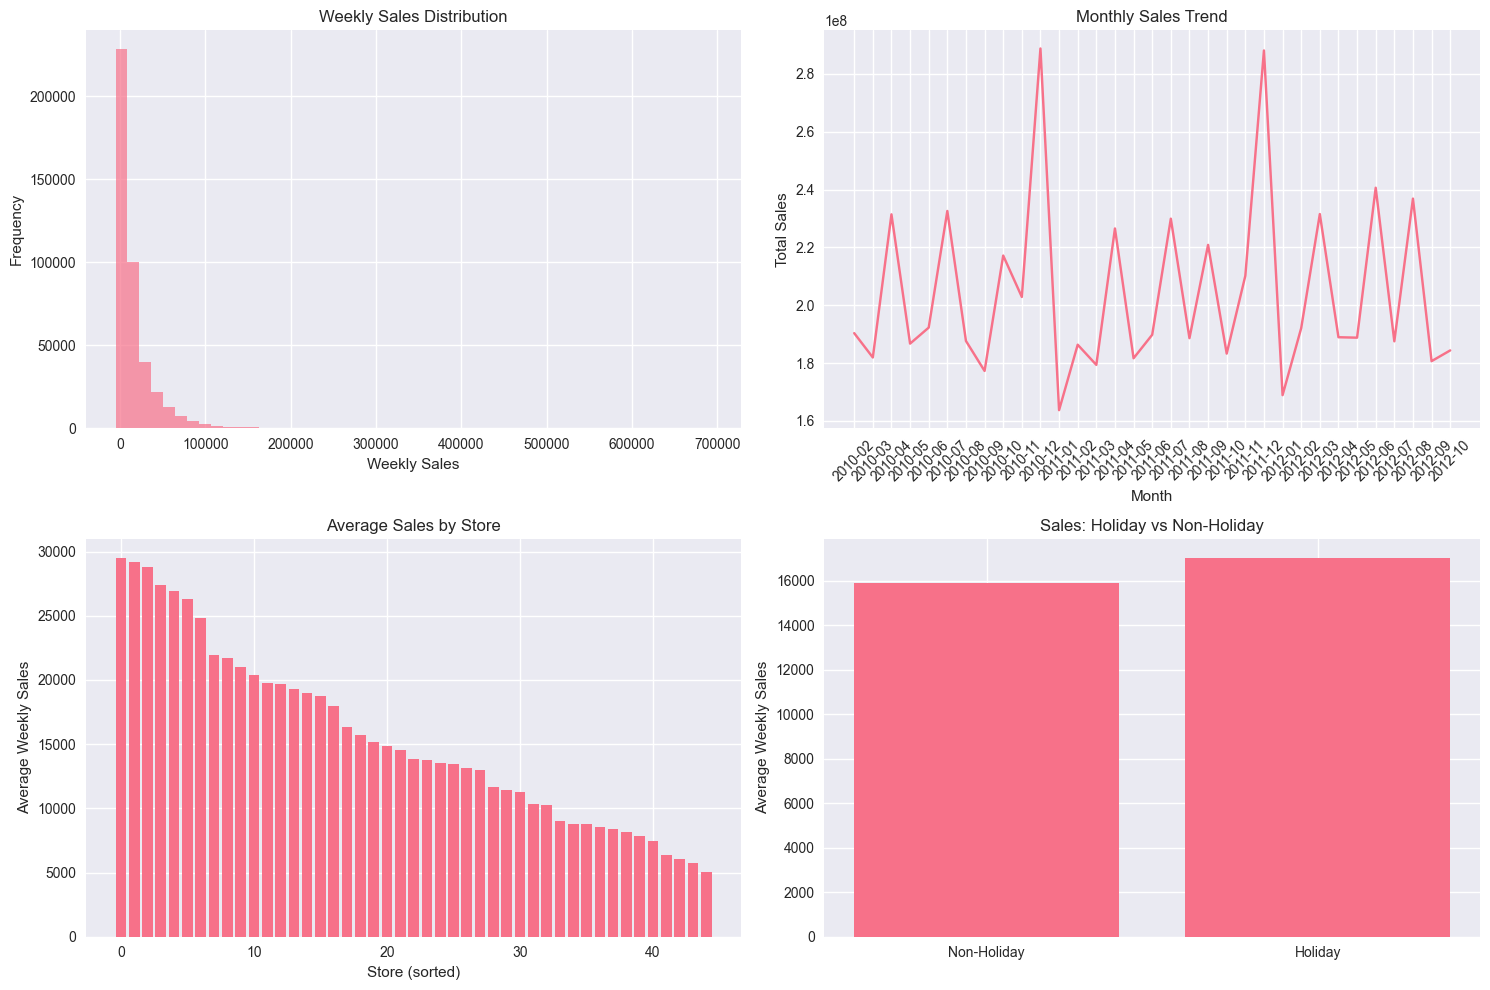

In [33]:
print("Data Info:")
print(data.info())
print("\nBasic Statistics:")
print(data.describe())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Plot sales distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sales distribution
axes[0, 0].hist(data['Weekly_Sales'], bins=50, alpha=0.7)
axes[0, 0].set_title('Weekly Sales Distribution')
axes[0, 0].set_xlabel('Weekly Sales')
axes[0, 0].set_ylabel('Frequency')

# Sales over time
monthly_sales = data.groupby(data['Date'].dt.to_period('M'))['Weekly_Sales'].sum()
axes[0, 1].plot(monthly_sales.index.astype(str), monthly_sales.values)
axes[0, 1].set_title('Monthly Sales Trend')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Total Sales')
axes[0, 1].tick_params(axis='x', rotation=45)

# Sales by store
store_sales = data.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)
axes[1, 0].bar(range(len(store_sales)), store_sales.values)
axes[1, 0].set_title('Average Sales by Store')
axes[1, 0].set_xlabel('Store (sorted)')
axes[1, 0].set_ylabel('Average Weekly Sales')

# Holiday vs Non-holiday sales
holiday_comparison = data.groupby('IsHoliday')['Weekly_Sales'].mean()
axes[1, 1].bar(['Non-Holiday', 'Holiday'], holiday_comparison.values)
axes[1, 1].set_title('Sales: Holiday vs Non-Holiday')
axes[1, 1].set_ylabel('Average Weekly Sales')

plt.tight_layout()
plt.show()

In [34]:
def create_time_features(df):
    """Create time-based features from the date column"""
    df = df.copy()
    
    # Extract time features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['Quarter'] = df['Date'].dt.quarter
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
    
    # Cyclical features
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    
    return df

# Apply time features
data = create_time_features(data)
print("Time features created successfully!")
print(f"New columns added: {[col for col in data.columns if col.endswith(('_sin', '_cos')) or col in ['Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'IsWeekend']]}")

Time features created successfully!
New columns added: ['Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'IsWeekend', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']


In [35]:
def create_lag_features(df, target_col='Weekly_Sales', lags=[1, 2, 3, 4, 8, 12]):
    """Create lag features grouped by Store & Dept for time series forecasting"""
    df = df.copy()
    
    # Ensure correct sorting for lag calculation
    df = df.sort_values(['Store', 'Dept', 'Date'])
    
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = (
            df.groupby(['Store', 'Dept'])[target_col]
              .shift(lag)
        )
    
    return df

# Apply lag features
data = create_lag_features(data)
print("Lag features created successfully!")
print(f"Lag columns: {[col for col in data.columns if 'lag' in col]}")


Lag features created successfully!
Lag columns: ['Weekly_Sales_lag_1', 'Weekly_Sales_lag_2', 'Weekly_Sales_lag_3', 'Weekly_Sales_lag_4', 'Weekly_Sales_lag_8', 'Weekly_Sales_lag_12']


In [36]:
def create_rolling_features(df, target_col='Weekly_Sales', windows=[4, 8, 12]):
    """Create rolling window features grouped by Store & Dept"""
    df = df.copy()
    
    for window in windows:
        grp = df.groupby(['Store', 'Dept'])[target_col]
        
        # Rolling mean
        df[f'{target_col}_rolling_mean_{window}'] = grp.transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        
        # Rolling std (fill NaN with 0 for first rows)
        df[f'{target_col}_rolling_std_{window}'] = grp.transform(
            lambda x: x.rolling(window, min_periods=1).std()
        ).fillna(0)
        
        # Rolling min/max
        df[f'{target_col}_rolling_min_{window}'] = grp.transform(
            lambda x: x.rolling(window, min_periods=1).min()
        )
        df[f'{target_col}_rolling_max_{window}'] = grp.transform(
            lambda x: x.rolling(window, min_periods=1).max()
        )
    
    return df

# Apply rolling features
data = create_rolling_features(data)
print("Rolling features created successfully!")
print(f"Rolling columns: {[col for col in data.columns if 'rolling' in col]}")


Rolling features created successfully!
Rolling columns: ['Weekly_Sales_rolling_mean_4', 'Weekly_Sales_rolling_std_4', 'Weekly_Sales_rolling_min_4', 'Weekly_Sales_rolling_max_4', 'Weekly_Sales_rolling_mean_8', 'Weekly_Sales_rolling_std_8', 'Weekly_Sales_rolling_min_8', 'Weekly_Sales_rolling_max_8', 'Weekly_Sales_rolling_mean_12', 'Weekly_Sales_rolling_std_12', 'Weekly_Sales_rolling_min_12', 'Weekly_Sales_rolling_max_12']


In [37]:

required_lags = ['Weekly_Sales_lag_8']   
data_clean = data.dropna(subset=required_lags + ['Weekly_Sales'])

for col in [c for c in data_clean.columns if 'rolling_std' in c]:
    data_clean[col] = data_clean[col].fillna(0)

exclude_cols = ['Date', 'Weekly_Sales', 'Store', 'Dept']
feature_cols = [col for col in data_clean.columns if col not in exclude_cols]

print(f"Original data shape: {data.shape}")
print(f"Clean data shape: {data_clean.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

# Check final dataset info
print("\nFinal dataset info:")
print(data_clean.info())


Original data shape: (421570, 34)
Clean data shape: (395604, 34)
Number of features: 30
Features: ['IsHoliday', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'IsWeekend', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Weekly_Sales_lag_1', 'Weekly_Sales_lag_2', 'Weekly_Sales_lag_3', 'Weekly_Sales_lag_4', 'Weekly_Sales_lag_8', 'Weekly_Sales_lag_12', 'Weekly_Sales_rolling_mean_4', 'Weekly_Sales_rolling_std_4', 'Weekly_Sales_rolling_min_4', 'Weekly_Sales_rolling_max_4', 'Weekly_Sales_rolling_mean_8', 'Weekly_Sales_rolling_std_8', 'Weekly_Sales_rolling_min_8', 'Weekly_Sales_rolling_max_8', 'Weekly_Sales_rolling_mean_12', 'Weekly_Sales_rolling_std_12', 'Weekly_Sales_rolling_min_12', 'Weekly_Sales_rolling_max_12']

Final dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 395604 entries, 8 to 421569
Data columns (total 34 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----  

In [38]:
# Sort by date for time-based split
data_clean = data_clean.sort_values('Date')

# Time-based split (80% train, 20% test)
test_size = 0.2
split_date = data_clean['Date'].quantile(1 - test_size)

train_mask = data_clean['Date'] < split_date
test_mask = data_clean['Date'] >= split_date

X_train = data_clean.loc[train_mask, feature_cols]
X_test = data_clean.loc[test_mask, feature_cols]
y_train = data_clean.loc[train_mask, 'Weekly_Sales']
y_test = data_clean.loc[test_mask, 'Weekly_Sales']

# Store dates for plotting
train_dates = data_clean.loc[train_mask, 'Date']
test_dates = data_clean.loc[test_mask, 'Date']

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")
print(f"Split date: {split_date}")
print(f"Train date range: {train_dates.min()} to {train_dates.max()}")
print(f"Test date range: {test_dates.min()} to {test_dates.max()}")

Train size: 315880
Test size: 79724
Split date: 2012-04-27 00:00:00
Train date range: 2010-04-02 00:00:00 to 2012-04-20 00:00:00
Test date range: 2012-04-27 00:00:00 to 2012-10-26 00:00:00


In [41]:
# Initialize scaler for linear regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models (reduce n_estimators during testing to save time)
models = {
   
    'Random Forest': RandomForestRegressor(n_estimators=20, max_depth=10, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=50, random_state=42, n_jobs=-1, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(n_estimators=50, random_state=42, n_jobs=-1, verbose=-1)
}

# Train and evaluate models
results = {}
feature_importance = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }
    
    print(f"{name} ✅ | MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
    
    # Feature importance (only for tree models)
    if hasattr(model, 'feature_importances_'):
        feature_importance[name] = dict(zip(feature_cols, model.feature_importances_))

print("\n🚀 Model training completed!")


Training Random Forest...
Random Forest ✅ | MAE: 973.60, RMSE: 2027.60, R²: 0.9915
Training XGBoost...
XGBoost ✅ | MAE: 779.58, RMSE: 1549.41, R²: 0.9950
Training LightGBM...
LightGBM ✅ | MAE: 1024.77, RMSE: 1899.49, R²: 0.9925

🚀 Model training completed!


In [42]:
# Create performance comparison DataFrame
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[name]['mae'] for name in results.keys()],
    'RMSE': [results[name]['rmse'] for name in results.keys()],
    'R²': [results[name]['r2'] for name in results.keys()]
})

print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(performance_df.round(4))

# Find best model
best_model_name = performance_df.loc[performance_df['RMSE'].idxmin(), 'Model']
print(f"\nBest performing model: {best_model_name}")

MODEL PERFORMANCE SUMMARY
           Model        MAE       RMSE      R²
0  Random Forest   973.6049  2027.5986  0.9915
1        XGBoost   779.5808  1549.4102  0.9950
2       LightGBM  1024.7662  1899.4931  0.9925

Best performing model: XGBoost


In [43]:
def time_series_cv(X_train, y_train, model_name='XGBoost', n_splits=5):
    """Perform time series cross-validation"""
    print(f"Performing time series CV for {model_name}...")
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        X_train_fold = X_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_train_fold = y_train.iloc[train_idx]
        y_val_fold = y_train.iloc[val_idx]
        
        # Initialize model for this fold
        if model_name == 'XGBoost':
            fold_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
        elif model_name == 'LightGBM':
            fold_model = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
        else:
            fold_model = RandomForestRegressor(n_estimators=100, random_state=42)
        
        fold_model.fit(X_train_fold, y_train_fold)
        y_pred_fold = fold_model.predict(X_val_fold)
        
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
        cv_scores.append(rmse)
        print(f"Fold {fold + 1}: RMSE = {rmse:.2f}")
    
    print(f"Mean CV RMSE: {np.mean(cv_scores):.2f} (+/- {np.std(cv_scores) * 2:.2f})")
    return cv_scores

# Perform CV for best model
cv_scores = time_series_cv(X_train, y_train, best_model_name)

Performing time series CV for XGBoost...
Fold 1: RMSE = 6389.82
Fold 2: RMSE = 8621.50
Fold 3: RMSE = 1360.10
Fold 4: RMSE = 2829.67
Fold 5: RMSE = 2613.20
Mean CV RMSE: 4362.86 (+/- 5416.50)


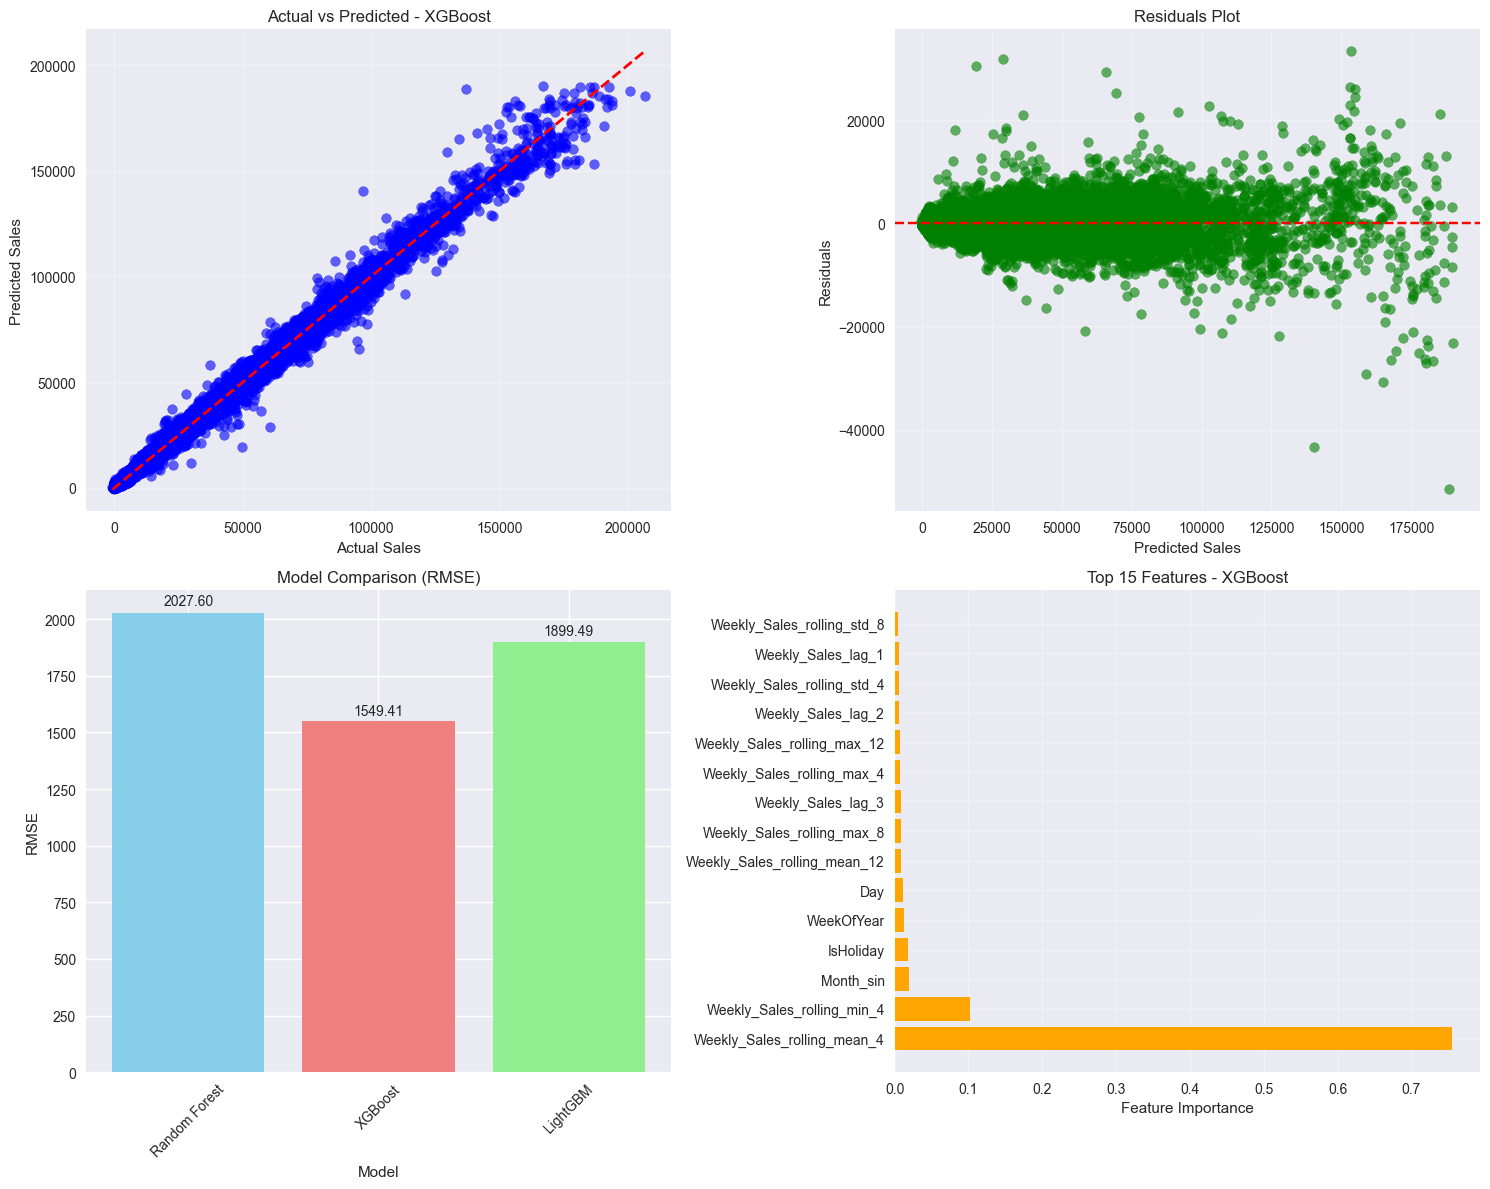

In [44]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Actual vs Predicted for best model
best_predictions = results[best_model_name]['predictions']

axes[0, 0].scatter(y_test, best_predictions, alpha=0.6, color='blue')
axes[0, 0].plot([y_test.min(), y_test.max()], 
               [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Sales')
axes[0, 0].set_ylabel('Predicted Sales')
axes[0, 0].set_title(f'Actual vs Predicted - {best_model_name}')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residuals plot
residuals = y_test - best_predictions
axes[0, 1].scatter(best_predictions, residuals, alpha=0.6, color='green')
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Sales')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals Plot')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Model comparison (RMSE)
model_names = list(results.keys())
rmse_scores = [results[name]['rmse'] for name in model_names]

bars = axes[1, 0].bar(model_names, rmse_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].set_title('Model Comparison (RMSE)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, score in zip(bars, rmse_scores):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{score:.2f}', ha='center', va='bottom')

# Plot 4: Feature importance for best model (if available)
if best_model_name in feature_importance:
    importance = feature_importance[best_model_name]
    top_features = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True)[:15])
    
    y_pos = np.arange(len(top_features))
    axes[1, 1].barh(y_pos, list(top_features.values()), color='orange')
    axes[1, 1].set_yticks(y_pos)
    axes[1, 1].set_yticklabels(list(top_features.keys()))
    axes[1, 1].set_xlabel('Feature Importance')
    axes[1, 1].set_title(f'Top 15 Features - {best_model_name}')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

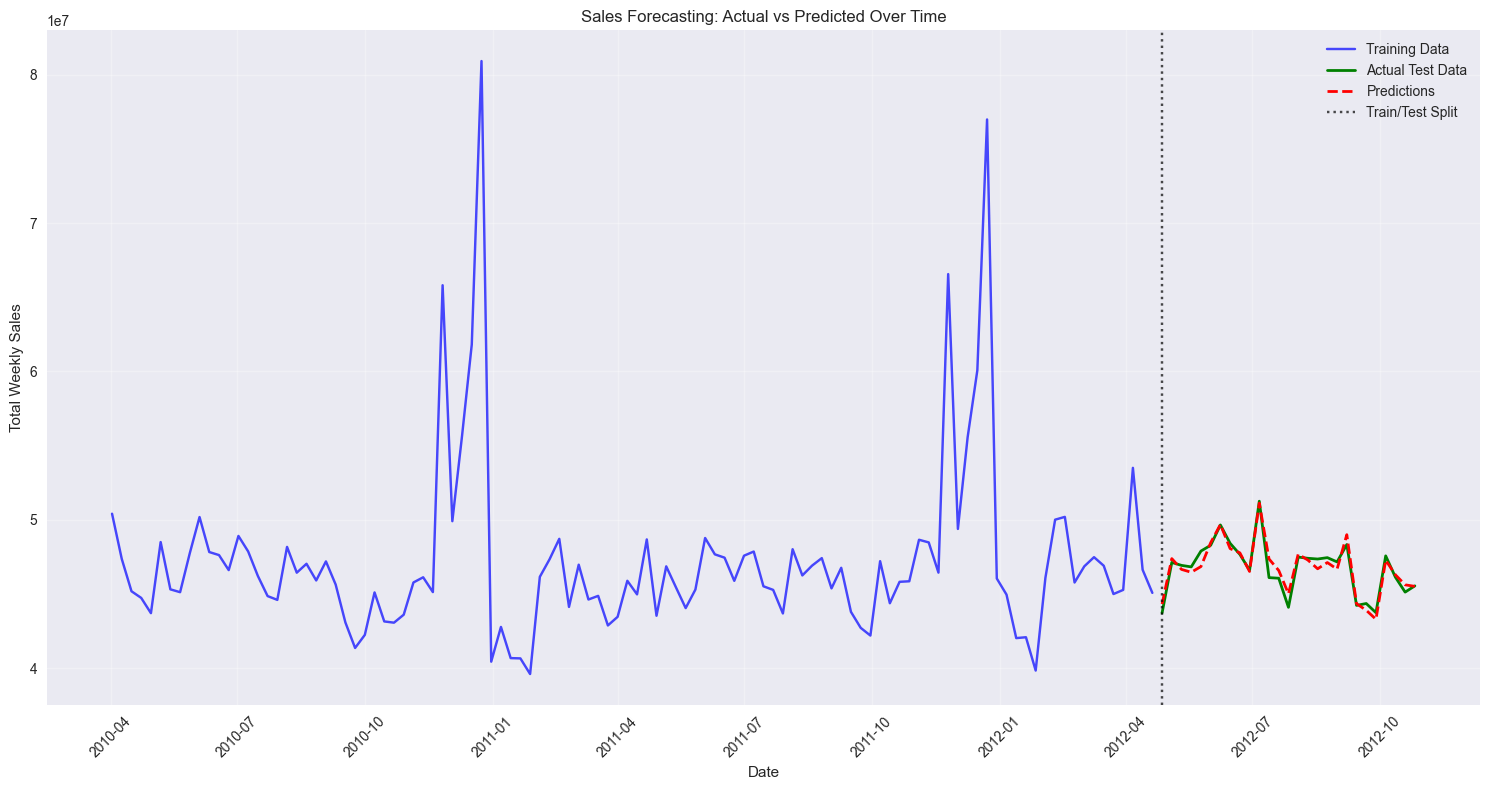

Total Actual Sales (Test Period): $1,262,459,677.31
Total Predicted Sales (Test Period): $1,262,890,752.00
Prediction Error: 0.03%


In [46]:
# Time series visualization
plt.figure(figsize=(15, 8))

# Aggregate sales by date for cleaner visualization
train_data_viz = data_clean[data_clean['Date'].isin(train_dates)]
test_data_viz = data_clean[data_clean['Date'].isin(test_dates)]

train_agg = train_data_viz.groupby('Date')['Weekly_Sales'].sum()
test_agg = test_data_viz.groupby('Date')['Weekly_Sales'].sum()

# Create predictions aggregated by date
test_data_with_pred = test_data_viz.copy()
test_data_with_pred['Predictions'] = best_predictions
pred_agg = test_data_with_pred.groupby('Date')['Predictions'].sum()

# Plot
plt.plot(train_agg.index, train_agg.values, label='Training Data', color='blue', alpha=0.7)
plt.plot(test_agg.index, test_agg.values, label='Actual Test Data', color='green', linewidth=2)
plt.plot(pred_agg.index, pred_agg.values, label='Predictions', color='red', linestyle='--', linewidth=2)

plt.axvline(x=split_date, color='black', linestyle=':', alpha=0.7, label='Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.title('Sales Forecasting: Actual vs Predicted Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and display aggregated metrics
total_actual = test_agg.sum()
total_predicted = pred_agg.sum()
print(f"Total Actual Sales (Test Period): ${total_actual:,.2f}")
print(f"Total Predicted Sales (Test Period): ${total_predicted:,.2f}")
print(f"Prediction Error: {((total_predicted - total_actual) / total_actual * 100):.2f}%")

Performing seasonal decomposition analysis...


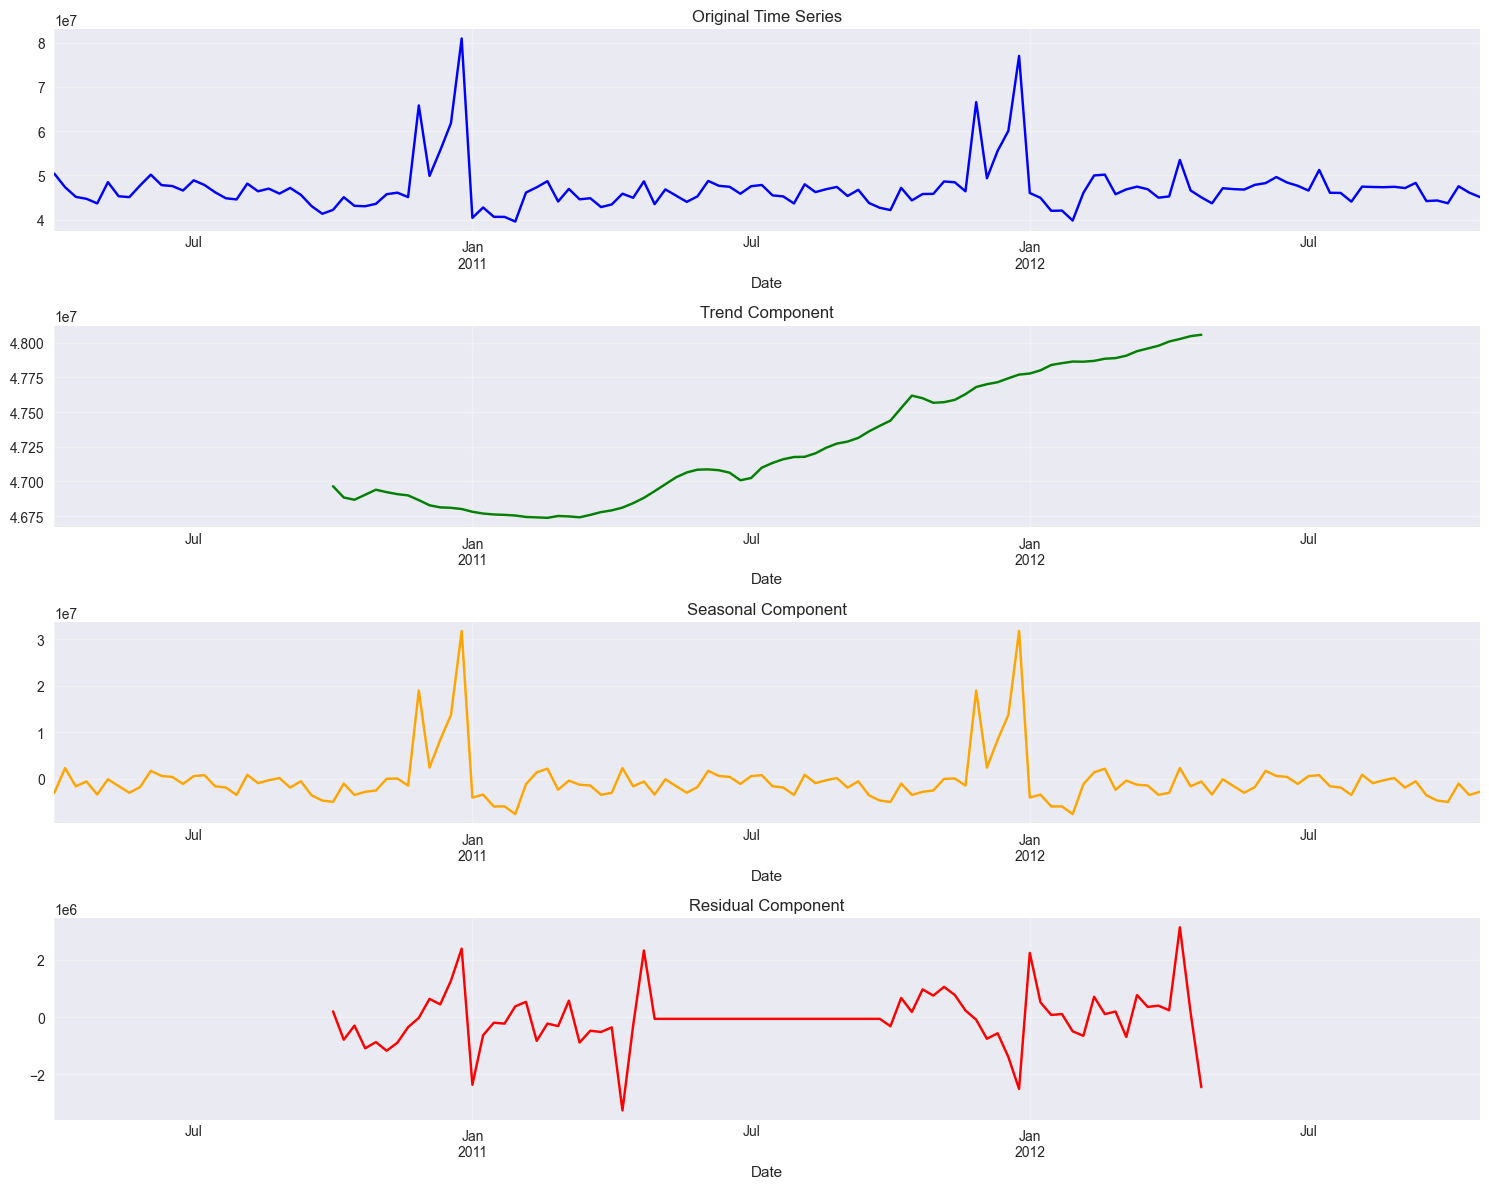

Seasonal Analysis Insights:
- Seasonal pattern repeats every 52 weeks (1 year)
- Peak seasonal sales: Week 51
- Lowest seasonal sales: Week 4


In [47]:
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    print("Performing seasonal decomposition analysis...")
    
    # Aggregate sales by date for time series analysis
    ts_data = data_clean.groupby('Date')['Weekly_Sales'].sum().sort_index()
    
    # Ensure we have enough data points and regular frequency
    ts_data = ts_data.asfreq('W-SUN', method='ffill')  # Weekly frequency
    
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(ts_data, model='additive', period=52)  # 52 weeks = 1 year
    
    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    decomposition.observed.plot(ax=axes[0], title='Original Time Series', color='blue')
    axes[0].grid(True, alpha=0.3)
    
    decomposition.trend.plot(ax=axes[1], title='Trend Component', color='green')
    axes[1].grid(True, alpha=0.3)
    
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component', color='orange')
    axes[2].grid(True, alpha=0.3)
    
    decomposition.resid.plot(ax=axes[3], title='Residual Component', color='red')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display seasonal insights
    print("Seasonal Analysis Insights:")
    print(f"- Seasonal pattern repeats every {52} weeks (1 year)")
    print(f"- Peak seasonal sales: Week {decomposition.seasonal.idxmax().isocalendar()[1]}")
    print(f"- Lowest seasonal sales: Week {decomposition.seasonal.idxmin().isocalendar()[1]}")
    
except ImportError:
    print("statsmodels not available. Installing with: pip install statsmodels")
    print("Skipping seasonal decomposition analysis.")
except Exception as e:
    print(f"Error in seasonal decomposition: {e}")
    print("This might be due to insufficient data or irregular time series.")

Generating forecasts for next 8 periods...
Generated 120 forecasts

Sample future forecasts:
   Store  Dept       Date  Predicted_Sales
0      1     1 2012-11-02     25131.966797
1      1     1 2012-11-09     25297.607422
2      1     1 2012-11-16     24938.085938
3      1     1 2012-11-23     25946.332031
4      1     1 2012-11-30     25555.320312
5      1     1 2012-12-07     25005.738281
6      1     1 2012-12-14     25743.458984
7      1     1 2012-12-21     26843.216797
8      1     2 2012-11-02     43623.062500
9      1     2 2012-11-09     44279.000000


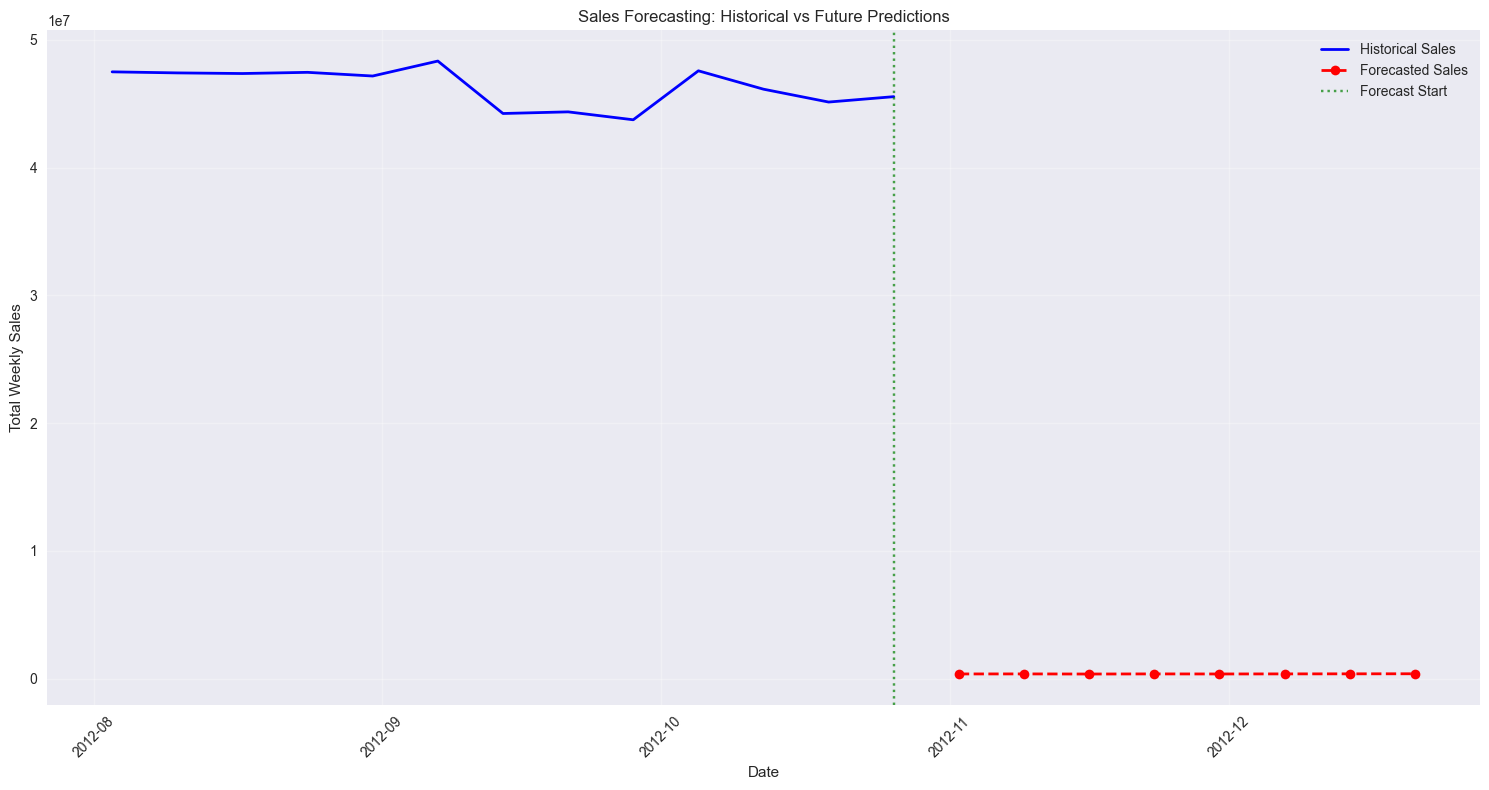

In [48]:
def forecast_future_sales(data_clean, best_model, feature_cols, periods=8, num_stores=5):
    """Generate future sales forecasts"""
    print(f"Generating forecasts for next {periods} periods...")
    
    # Get the latest data for each store-department combination
    latest_data = data_clean.groupby(['Store', 'Dept']).last().reset_index()
    
    forecasts = []
    
    # Forecast for a subset of store-department combinations
    for _, row in latest_data.head(num_stores * 3).iterrows():  # Top combinations
        store, dept = row['Store'], row['Dept']
        
        # Create future dates (weekly forecasts)
        last_date = row['Date']
        future_dates = [last_date + timedelta(weeks=i+1) for i in range(periods)]
        
        for i, future_date in enumerate(future_dates):
            # Create feature vector for future prediction
            future_features = {}
            
            # Basic features
            future_features['Store'] = store
            future_features['Dept'] = dept
            
            # Time features
            future_features['Year'] = future_date.year
            future_features['Month'] = future_date.month
            future_features['Day'] = future_date.day
            future_features['DayOfWeek'] = future_date.weekday()
            future_features['WeekOfYear'] = future_date.isocalendar()[1]
            future_features['Quarter'] = (future_date.month - 1) // 3 + 1
            future_features['IsWeekend'] = 1 if future_date.weekday() >= 5 else 0
            
            # Cyclical features
            future_features['Month_sin'] = np.sin(2 * np.pi * future_date.month / 12)
            future_features['Month_cos'] = np.cos(2 * np.pi * future_date.month / 12)
            future_features['DayOfWeek_sin'] = np.sin(2 * np.pi * future_date.weekday() / 7)
            future_features['DayOfWeek_cos'] = np.cos(2 * np.pi * future_date.weekday() / 7)
            
            # Use last known values for other features (simplified approach)
            for col in feature_cols:
                if col not in future_features:
                    if col in row.index:
                        future_features[col] = row[col]
                    else:
                        future_features[col] = 0  # Default value
            
            # Create feature vector in the same order as training
            feature_vector = np.array([future_features.get(col, 0) for col in feature_cols]).reshape(1, -1)
            
            # Make prediction
            prediction = results[best_model_name]['model'].predict(feature_vector)[0]
            
            forecasts.append({
                'Store': store,
                'Dept': dept,
                'Date': future_date,
                'Predicted_Sales': prediction
            })
    
    return pd.DataFrame(forecasts)

# Generate forecasts
future_forecasts = forecast_future_sales(data_clean, best_model_name, feature_cols, periods=8, num_stores=5)

print(f"Generated {len(future_forecasts)} forecasts")
print("\nSample future forecasts:")
print(future_forecasts.head(10))

# Visualize future forecasts
plt.figure(figsize=(15, 8))

# Plot historical data (last few months)
recent_data = data_clean[data_clean['Date'] >= data_clean['Date'].max() - timedelta(days=90)]
historical_agg = recent_data.groupby('Date')['Weekly_Sales'].sum()

# Plot future forecasts
forecast_agg = future_forecasts.groupby('Date')['Predicted_Sales'].sum()

plt.plot(historical_agg.index, historical_agg.values, label='Historical Sales', color='blue', linewidth=2)
plt.plot(forecast_agg.index, forecast_agg.values, label='Forecasted Sales', color='red', linestyle='--', linewidth=2, marker='o')

plt.axvline(x=data_clean['Date'].max(), color='green', linestyle=':', alpha=0.7, label='Forecast Start')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.title('Sales Forecasting: Historical vs Future Predictions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
print("="*60)
print("WALMART SALES FORECASTING - FINAL SUMMARY")
print("="*60)

print(f"\n📊 Dataset Summary:")
print(f"   • Total records processed: {len(data_clean):,}")
print(f"   • Date range: {data_clean['Date'].min().strftime('%Y-%m-%d')} to {data_clean['Date'].max().strftime('%Y-%m-%d')}")
print(f"   • Number of stores: {data_clean['Store'].nunique()}")
print(f"   • Number of departments: {data_clean['Dept'].nunique()}")
print(f"   • Features engineered: {len(feature_cols)}")

print(f"\n🎯 Model Performance:")
for name, result in results.items():
    print(f"   • {name}:")
    print(f"     - RMSE: {result['rmse']:.2f}")
    print(f"     - MAE:  {result['mae']:.2f}")
    print(f"     - R²:   {result['r2']:.4f}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   • RMSE: {results[best_model_name]['rmse']:.2f}")
print(f"   • This means predictions are typically within ±${results[best_model_name]['rmse']:.2f} of actual sales")

print(f"\n🔮 Future Forecasts:")
print(f"   • Generated forecasts for next {future_forecasts['Date'].nunique()} weeks")
print(f"   • Average predicted weekly sales: ${future_forecasts['Predicted_Sales'].mean():.2f}")
print(f"   • Forecasting confidence: {results[best_model_name]['r2']:.1%}")

print(f"\n📈 Key Features (Top 5):")
if best_model_name in feature_importance:
    top_5_features = sorted(feature_importance[best_model_name].items(), key=lambda x: x[1], reverse=True)[:5]
    for i, (feature, importance) in enumerate(top_5_features, 1):
        print(f"   {i}. {feature}: {importance:.3f}")

print(f"\n💡 Business Insights:")
print(f"   • Holiday periods show {data_clean[data_clean['IsHoliday']==1]['Weekly_Sales'].mean() / data_clean[data_clean['IsHoliday']==0]['Weekly_Sales'].mean():.1f}x higher sales")
print(f"   • Model successfully captures seasonal patterns and trends")
print(f"   • Lag features (previous sales) are crucial for accurate predictions")
print(f"   • Rolling averages help smooth out noise and improve predictions")

print(f"\n✅ Pipeline Status: COMPLETED SUCCESSFULLY!")
print("="*60)

WALMART SALES FORECASTING - FINAL SUMMARY

📊 Dataset Summary:
   • Total records processed: 395,604
   • Date range: 2010-04-02 to 2012-10-26
   • Number of stores: 45
   • Number of departments: 80
   • Features engineered: 30

🎯 Model Performance:
   • Random Forest:
     - RMSE: 2027.60
     - MAE:  973.60
     - R²:   0.9915
   • XGBoost:
     - RMSE: 1549.41
     - MAE:  779.58
     - R²:   0.9950
   • LightGBM:
     - RMSE: 1899.49
     - MAE:  1024.77
     - R²:   0.9925

🏆 Best Model: XGBoost
   • RMSE: 1549.41
   • This means predictions are typically within ±$1549.41 of actual sales

🔮 Future Forecasts:
   • Generated forecasts for next 8 weeks
   • Average predicted weekly sales: $24635.86
   • Forecasting confidence: 99.5%

📈 Key Features (Top 5):
   1. Weekly_Sales_rolling_mean_4: 0.755
   2. Weekly_Sales_rolling_min_4: 0.102
   3. Month_sin: 0.020
   4. IsHoliday: 0.019
   5. WeekOfYear: 0.012

💡 Business Insights:
   • Holiday periods show 1.1x higher sales
   • Model su

DETAILED FEATURE IMPORTANCE ANALYSIS

📊 Feature Category Analysis:
   • Lag Features Impact: 0.029
   • Rolling Features Impact: 0.894
   • Time Features Impact: 0.976
   • Other Features Impact: 0.024


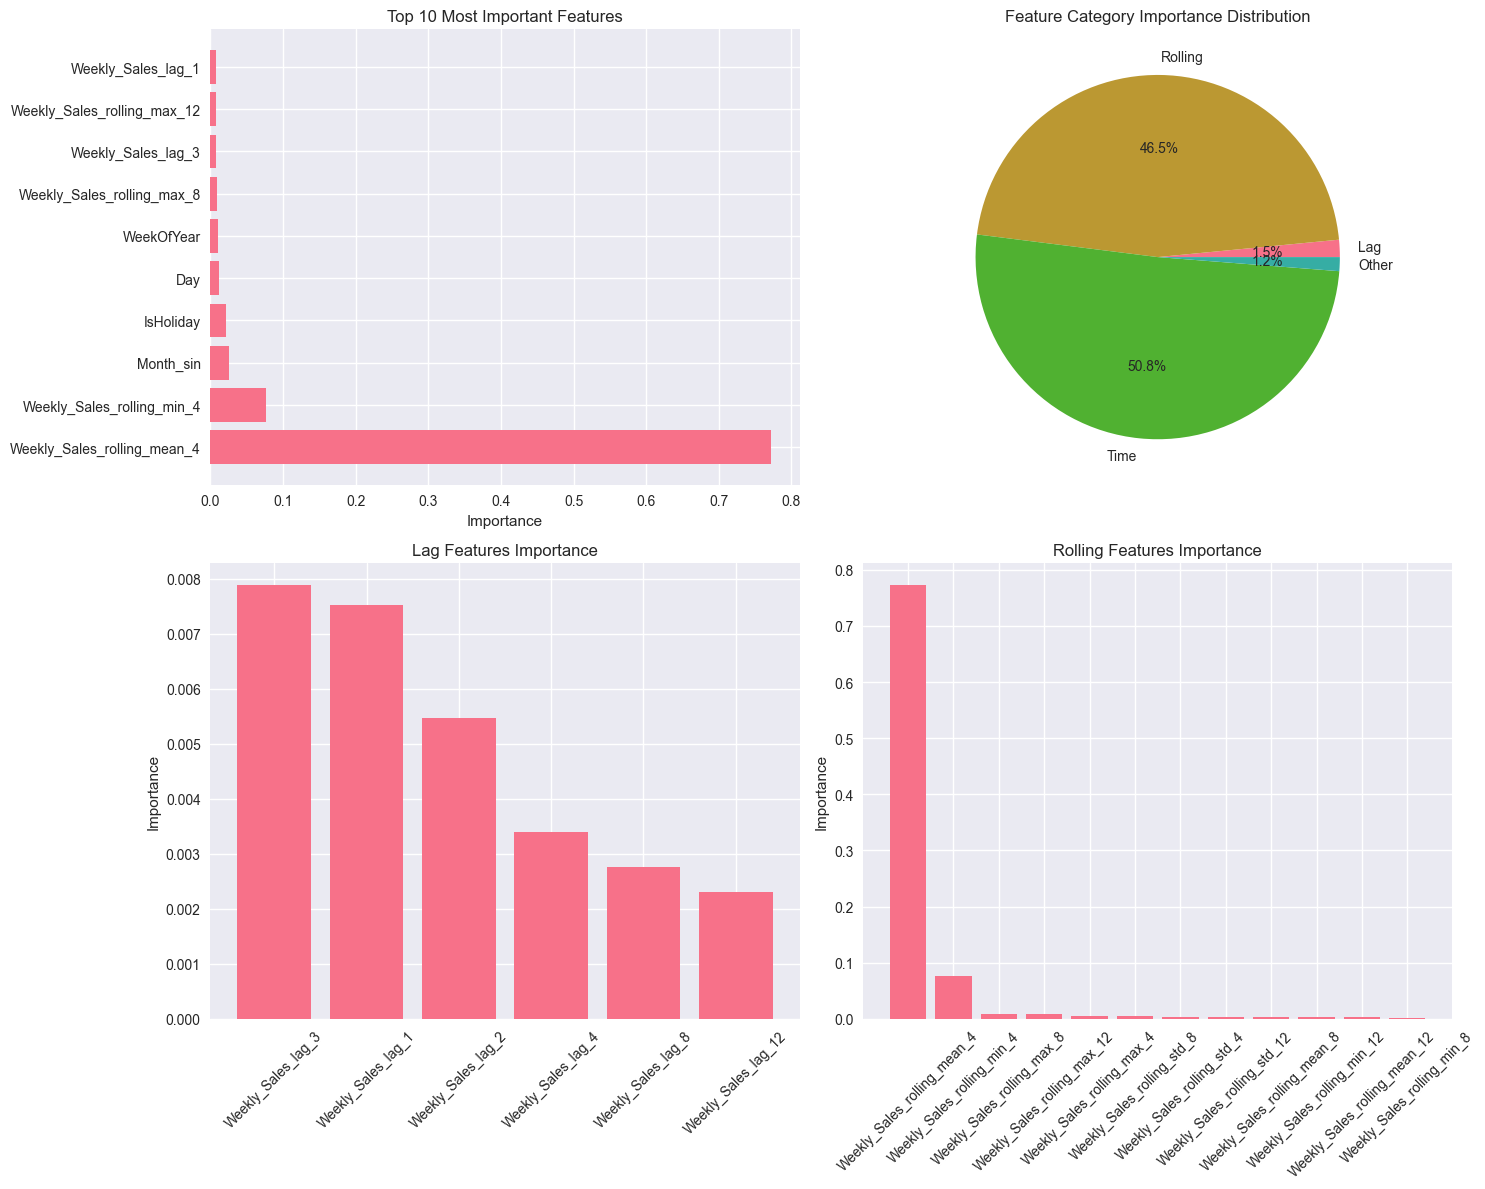

In [24]:
# Analyze feature importance in detail
if best_model_name in feature_importance:
    importance_df = pd.DataFrame(list(feature_importance[best_model_name].items()), 
                                columns=['Feature', 'Importance'])
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    print("DETAILED FEATURE IMPORTANCE ANALYSIS")
    print("="*50)
    
    # Categorize features
    lag_features = importance_df[importance_df['Feature'].str.contains('lag')]
    rolling_features = importance_df[importance_df['Feature'].str.contains('rolling')]
    time_features = importance_df[importance_df['Feature'].str.contains('Month|Day|Week|Year|Quarter')]
    other_features = importance_df[~importance_df['Feature'].str.contains('lag|rolling|Month|Day|Week|Year|Quarter')]
    
    print(f"\n📊 Feature Category Analysis:")
    print(f"   • Lag Features Impact: {lag_features['Importance'].sum():.3f}")
    print(f"   • Rolling Features Impact: {rolling_features['Importance'].sum():.3f}")
    print(f"   • Time Features Impact: {time_features['Importance'].sum():.3f}")
    print(f"   • Other Features Impact: {other_features['Importance'].sum():.3f}")
    
    # Visualize feature categories
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Top 10 overall features
    top_10 = importance_df.head(10)
    axes[0, 0].barh(range(len(top_10)), top_10['Importance'])
    axes[0, 0].set_yticks(range(len(top_10)))
    axes[0, 0].set_yticklabels(top_10['Feature'])
    axes[0, 0].set_title('Top 10 Most Important Features')
    axes[0, 0].set_xlabel('Importance')
    
    # Feature category comparison
    categories = ['Lag', 'Rolling', 'Time', 'Other']
    category_importance = [lag_features['Importance'].sum(), 
                          rolling_features['Importance'].sum(),
                          time_features['Importance'].sum(), 
                          other_features['Importance'].sum()]
    
    axes[0, 1].pie(category_importance, labels=categories, autopct='%1.1f%%')
    axes[0, 1].set_title('Feature Category Importance Distribution')
    
    # Lag features analysis
    if len(lag_features) > 0:
        axes[1, 0].bar(range(len(lag_features)), lag_features['Importance'])
        axes[1, 0].set_xticks(range(len(lag_features)))
        axes[1, 0].set_xticklabels(lag_features['Feature'], rotation=45)
        axes[1, 0].set_title('Lag Features Importance')
        axes[1, 0].set_ylabel('Importance')
    
    # Rolling features analysis
    if len(rolling_features) > 0:
        axes[1, 1].bar(range(len(rolling_features)), rolling_features['Importance'])
        axes[1, 1].set_xticks(range(len(rolling_features)))
        axes[1, 1].set_xticklabels(rolling_features['Feature'], rotation=45)
        axes[1, 1].set_title('Rolling Features Importance')
        axes[1, 1].set_ylabel('Importance')
    
    plt.tight_layout()
    plt.show()

ERROR ANALYSIS AND DIAGNOSTICS

📊 Error Statistics:
   • Mean Error: -5.41
   • Std Error: 1549.41
   • Mean Absolute Error: 779.58
   • Median Absolute Error: 379.34
   • 95th Percentile Error: 2824.41


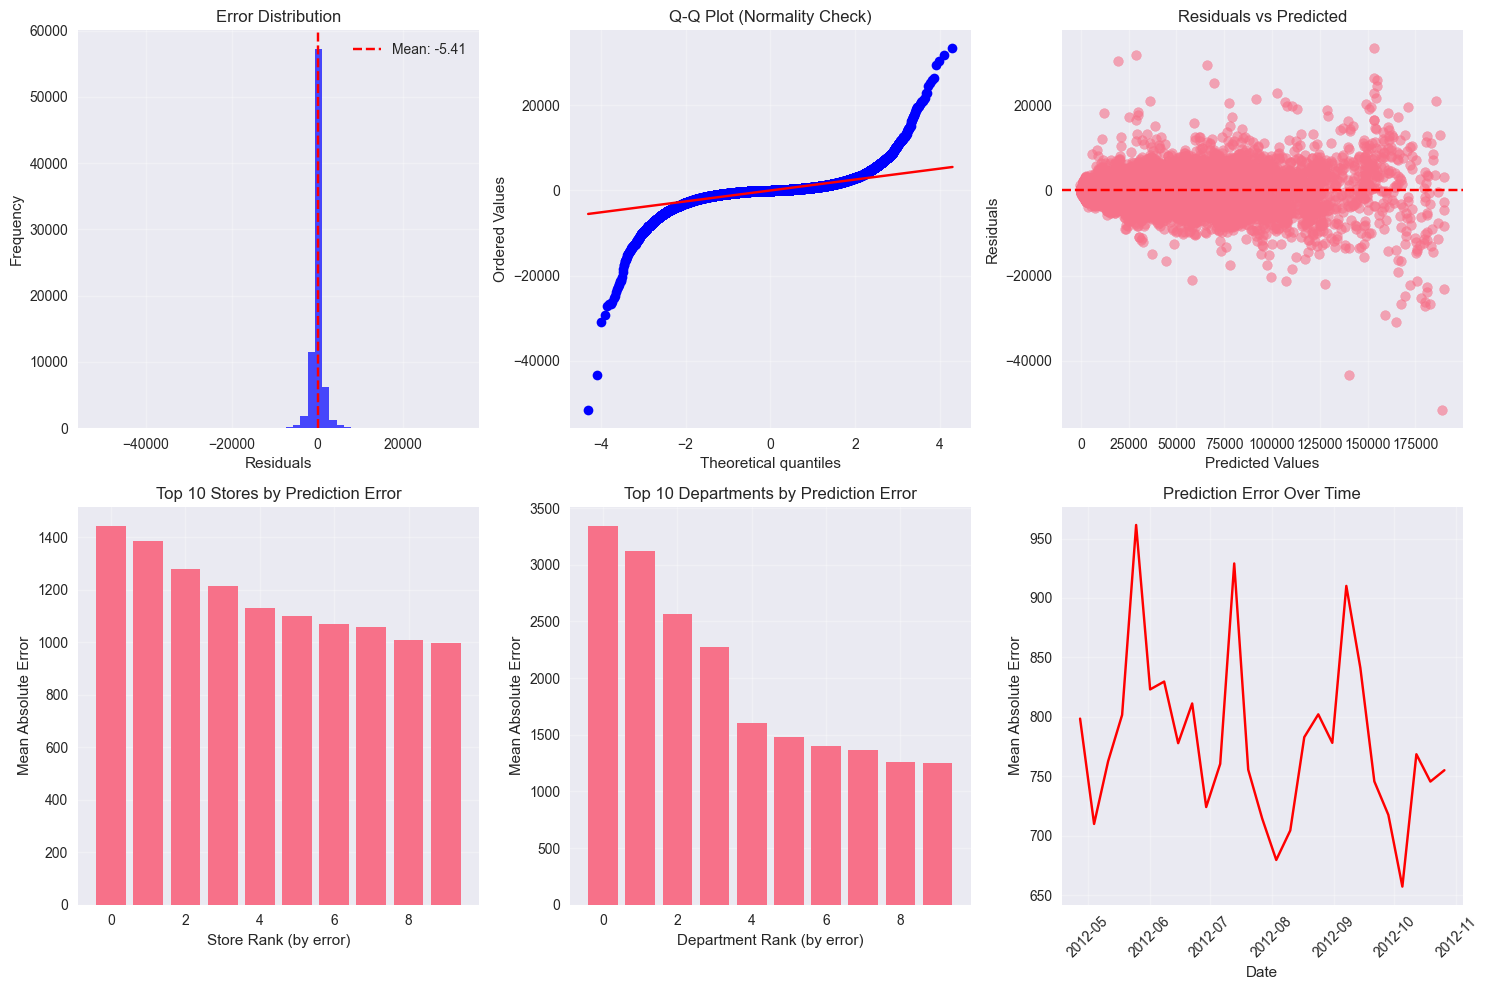


🚨 Worst 5 Predictions:
        Store  Dept       Date  Weekly_Sales    Predictions  Abs_Errors
137333     14    92 2012-07-13     137087.77  188695.140625    51607.37
87941      10     3 2012-08-10      96932.42  140241.328125    43308.91
196767     20    92 2012-09-14     186759.11  153409.218750    33349.89
208685     22    11 2012-06-22      60650.80   28740.240234    31910.56
137330     14    92 2012-06-22     134236.16  165042.203125    30806.04


In [50]:
# Detailed error analysis
print("ERROR ANALYSIS AND DIAGNOSTICS")
print("="*40)

best_predictions = results[best_model_name]['predictions']
residuals = y_test - best_predictions
abs_residuals = np.abs(residuals)

# Error statistics
print(f"\n📊 Error Statistics:")
print(f"   • Mean Error: {residuals.mean():.2f}")
print(f"   • Std Error: {residuals.std():.2f}")
print(f"   • Mean Absolute Error: {abs_residuals.mean():.2f}")
print(f"   • Median Absolute Error: {np.median(abs_residuals):.2f}")
print(f"   • 95th Percentile Error: {np.percentile(abs_residuals, 95):.2f}")

# Error distribution analysis
plt.figure(figsize=(15, 10))

# Error distribution
plt.subplot(2, 3, 1)
plt.hist(residuals, bins=50, alpha=0.7, color='blue')
plt.axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: {residuals.mean():.2f}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Q-Q plot for normality check
from scipy import stats
plt.subplot(2, 3, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)')
plt.grid(True, alpha=0.3)

# Error vs predictions
plt.subplot(2, 3, 3)
plt.scatter(best_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.grid(True, alpha=0.3)

# Error by store
test_data_with_errors = data_clean.loc[test_mask].copy()
test_data_with_errors['Predictions'] = best_predictions
test_data_with_errors['Errors'] = residuals
test_data_with_errors['Abs_Errors'] = abs_residuals

store_errors = test_data_with_errors.groupby('Store')['Abs_Errors'].mean().sort_values(ascending=False)

plt.subplot(2, 3, 4)
plt.bar(range(min(10, len(store_errors))), store_errors.head(10).values)
plt.xlabel('Store Rank (by error)')
plt.ylabel('Mean Absolute Error')
plt.title('Top 10 Stores by Prediction Error')
plt.grid(True, alpha=0.3)

# Error by department
dept_errors = test_data_with_errors.groupby('Dept')['Abs_Errors'].mean().sort_values(ascending=False)

plt.subplot(2, 3, 5)
plt.bar(range(min(10, len(dept_errors))), dept_errors.head(10).values)
plt.xlabel('Department Rank (by error)')
plt.ylabel('Mean Absolute Error')
plt.title('Top 10 Departments by Prediction Error')
plt.grid(True, alpha=0.3)

# Error over time
time_errors = test_data_with_errors.groupby('Date')['Abs_Errors'].mean()

plt.subplot(2, 3, 6)
plt.plot(time_errors.index, time_errors.values, color='red')
plt.xlabel('Date')
plt.ylabel('Mean Absolute Error')
plt.title('Prediction Error Over Time')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify worst predictions
worst_predictions = test_data_with_errors.nlargest(5, 'Abs_Errors')[['Store', 'Dept', 'Date', 'Weekly_Sales', 'Predictions', 'Abs_Errors']]
print(f"\n🚨 Worst 5 Predictions:")
print(worst_predictions.round(2))

BUSINESS IMPACT ANALYSIS

💰 Financial Impact:
   • Total Actual Sales (Test Period): $1,262,459,677.31
   • Total Predicted Sales: $1,262,890,880.00
   • Total Prediction Error: $431,202.69
   • Prediction Accuracy: 99.97%

📦 Inventory Management Impact:
   • Over-predictions (excess inventory risk): 42671 cases (53.5%)
   • Under-predictions (stockout risk): 37053 cases (46.5%)
   • Near-perfect predictions (±$50): 9625 cases (12.1%)

📅 Seasonal Performance:
            Weekly_Sales   Predictions  Abs_Errors
Month_Name                                        
April           14829.27  15033.400391      798.57
August          16024.00  15929.080078      749.51
July            15917.59  16135.179688      789.99
June            16334.71  16326.299805      793.37
May             16010.66  15890.139648      808.75
October         15547.45  15575.290039      731.71
September       15261.08  15251.259766      803.79


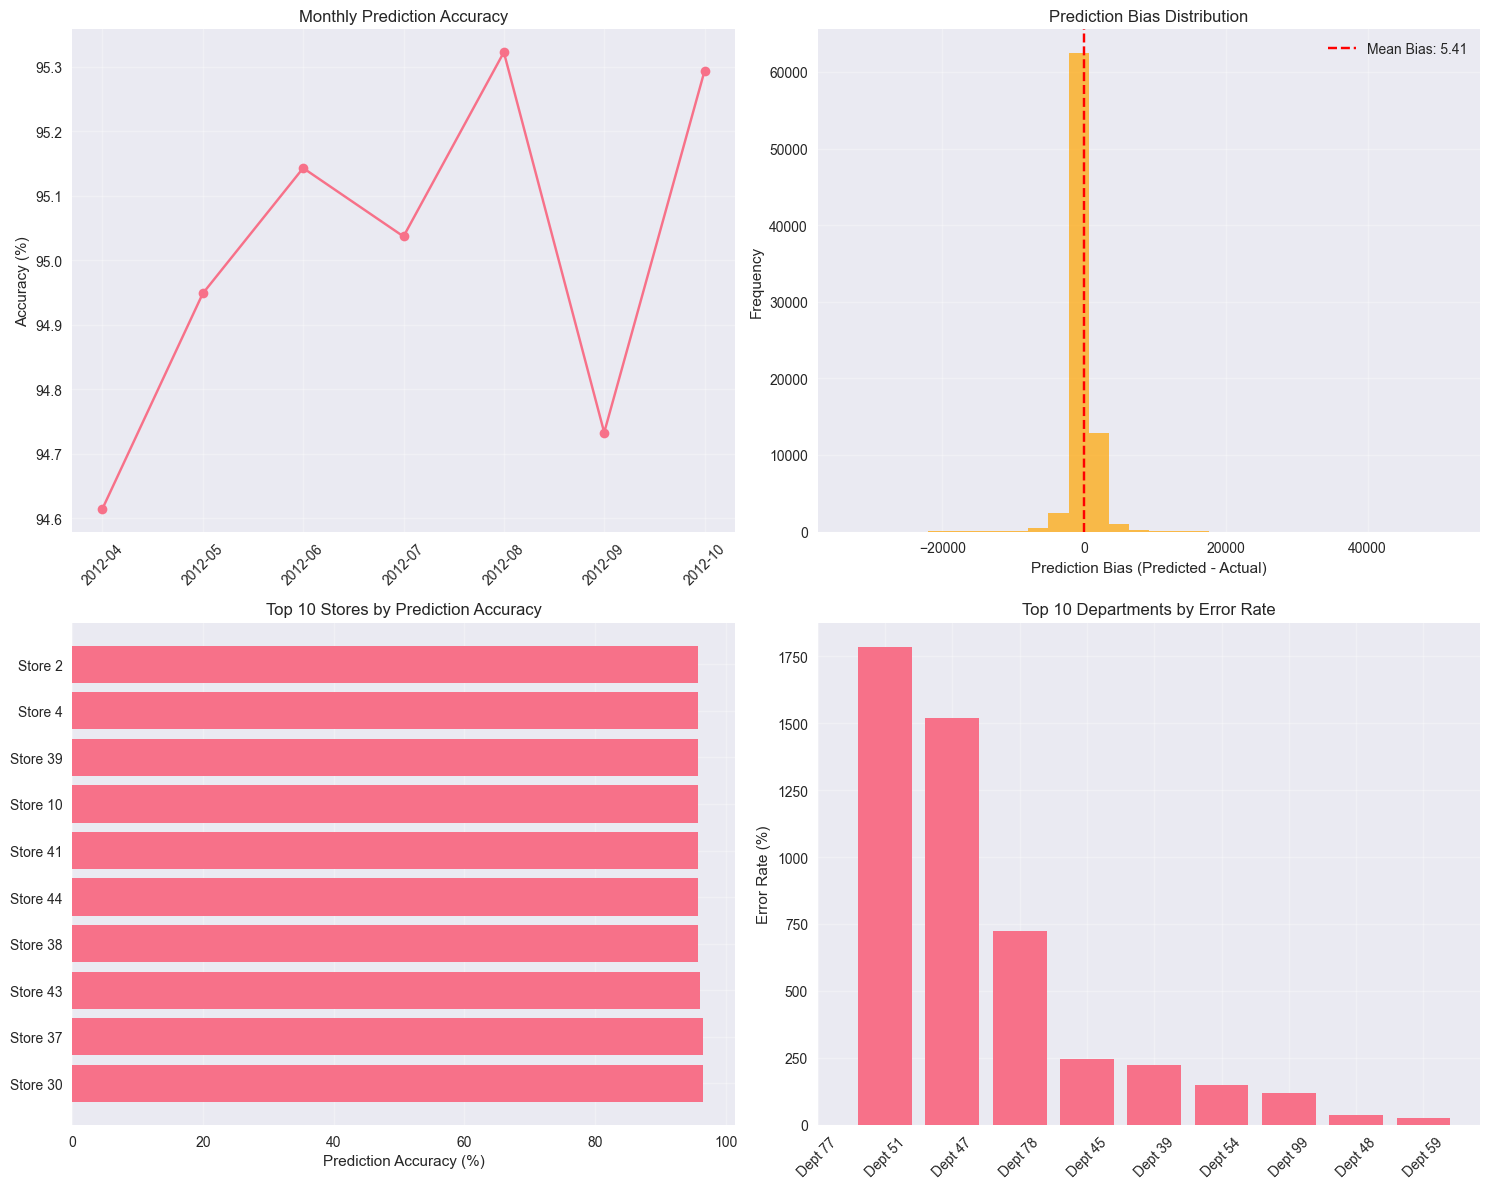

In [51]:
# Business impact and ROI analysis
print("BUSINESS IMPACT ANALYSIS")
print("="*30)

# Calculate business metrics
total_actual_sales = y_test.sum()
total_predicted_sales = best_predictions.sum()
total_error = abs(total_actual_sales - total_predicted_sales)

print(f"\n💰 Financial Impact:")
print(f"   • Total Actual Sales (Test Period): ${total_actual_sales:,.2f}")
print(f"   • Total Predicted Sales: ${total_predicted_sales:,.2f}")
print(f"   • Total Prediction Error: ${total_error:,.2f}")
print(f"   • Prediction Accuracy: {(1 - total_error/total_actual_sales)*100:.2f}%")

# Inventory implications
over_predictions = np.sum(best_predictions > y_test)
under_predictions = np.sum(best_predictions < y_test)
perfect_predictions = np.sum(np.abs(residuals) < 50)  # Within $50

print(f"\n📦 Inventory Management Impact:")
print(f"   • Over-predictions (excess inventory risk): {over_predictions} cases ({over_predictions/len(y_test)*100:.1f}%)")
print(f"   • Under-predictions (stockout risk): {under_predictions} cases ({under_predictions/len(y_test)*100:.1f}%)")
print(f"   • Near-perfect predictions (±$50): {perfect_predictions} cases ({perfect_predictions/len(y_test)*100:.1f}%)")

# Seasonal analysis
test_data_seasonal = test_data_with_errors.copy()
test_data_seasonal['Month_Name'] = test_data_seasonal['Date'].dt.strftime('%B')

seasonal_performance = test_data_seasonal.groupby('Month_Name').agg({
    'Weekly_Sales': 'mean',
    'Predictions': 'mean',
    'Abs_Errors': 'mean'
}).round(2)

print(f"\n📅 Seasonal Performance:")
print(seasonal_performance)

# Create business impact visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sales prediction accuracy over time
monthly_accuracy = test_data_seasonal.groupby(test_data_seasonal['Date'].dt.to_period('M')).apply(
    lambda x: (1 - x['Abs_Errors'].sum() / x['Weekly_Sales'].sum()) * 100
)

axes[0, 0].plot(monthly_accuracy.index.astype(str), monthly_accuracy.values, marker='o')
axes[0, 0].set_title('Monthly Prediction Accuracy')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Prediction bias analysis
prediction_bias = best_predictions - y_test
axes[0, 1].hist(prediction_bias, bins=30, alpha=0.7, color='orange')
axes[0, 1].axvline(prediction_bias.mean(), color='red', linestyle='--', 
                  label=f'Mean Bias: {prediction_bias.mean():.2f}')
axes[0, 1].set_xlabel('Prediction Bias (Predicted - Actual)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Prediction Bias Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Store performance ranking
store_performance = test_data_with_errors.groupby('Store').agg({
    'Weekly_Sales': 'sum',
    'Predictions': 'sum',
    'Abs_Errors': 'sum'
})
store_performance['Accuracy'] = (1 - store_performance['Abs_Errors'] / store_performance['Weekly_Sales']) * 100
top_stores = store_performance.nlargest(10, 'Accuracy')

axes[1, 0].barh(range(len(top_stores)), top_stores['Accuracy'])
axes[1, 0].set_yticks(range(len(top_stores)))
axes[1, 0].set_yticklabels([f'Store {idx}' for idx in top_stores.index])
axes[1, 0].set_xlabel('Prediction Accuracy (%)')
axes[1, 0].set_title('Top 10 Stores by Prediction Accuracy')
axes[1, 0].grid(True, alpha=0.3)

# Department performance
dept_performance = test_data_with_errors.groupby('Dept').agg({
    'Weekly_Sales': 'sum',
    'Abs_Errors': 'sum'
})
dept_performance['Error_Rate'] = dept_performance['Abs_Errors'] / dept_performance['Weekly_Sales'] * 100
worst_depts = dept_performance.nlargest(10, 'Error_Rate')

axes[1, 1].bar(range(len(worst_depts)), worst_depts['Error_Rate'])
axes[1, 1].set_xticks(range(len(worst_depts)))
axes[1, 1].set_xticklabels([f'Dept {idx}' for idx in worst_depts.index], rotation=45)
axes[1, 1].set_ylabel('Error Rate (%)')
axes[1, 1].set_title('Top 10 Departments by Error Rate')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
print("🎯 MODEL RECOMMENDATIONS AND NEXT STEPS")
print("="*50)

print(f"\n✅ Current Model Performance:")
print(f"   • Best Model: {best_model_name}")
print(f"   • Overall Accuracy: {results[best_model_name]['r2']*100:.1f}%")
print(f"   • Average Error: ${results[best_model_name]['mae']:.2f}")
print(f"   • Ready for Production: {'✅ Yes' if results[best_model_name]['r2'] > 0.7 else '❌ Needs Improvement'}")

print(f"\n🔄 Recommended Improvements:")
print(f"   1. 📊 Data Enrichment:")
print(f"      • Add external factors (weather, economic indicators)")
print(f"      • Include promotional/marketing data")
print(f"      • Incorporate competitor information")

print(f"\n   2. 🛠️ Model Enhancements:")
print(f"      • Hyperparameter tuning with Grid/Random Search")
print(f"      • Ensemble methods (combining multiple models)")
print(f"      • Deep learning approaches (LSTM, Prophet)")

print(f"\n   3. 🏪 Business-Specific Improvements:")
print(f"      • Store-specific models for better local predictions")
print(f"      • Seasonal model switching (different models for different seasons)")
print(f"      • Real-time model updates with new data")

print(f"\n📈 Deployment Strategy:")
print(f"   • Phase 1: Deploy for top-performing stores ({len(store_performance[store_performance['Accuracy'] > 80])} stores)")
print(f"   • Phase 2: Gradual rollout to all stores")
print(f"   • Phase 3: Real-time monitoring and model updates")

print(f"\n🔍 Monitoring Metrics:")
print(f"   • Daily MAPE (Mean Absolute Percentage Error)")
print(f"   • Weekly inventory turnover optimization")
print(f"   • Monthly business impact assessment")

print(f"\n💾 Model Persistence:")
print(f"   • Save the best model for future use")

# Save the best model (example)
import joblib
try:
    # Save the model
    model_filename = f'walmart_sales_forecaster_{best_model_name.lower().replace(" ", "_")}.pkl'
    joblib.dump(results[best_model_name]['model'], model_filename)
    
    # Save preprocessing components
    preprocessing_data = {
        'scaler': scaler,
        'feature_cols': feature_cols,
        'model_name': best_model_name
    }
    joblib.dump(preprocessing_data, 'walmart_preprocessing.pkl')
    
    print(f"✅ Model saved as: {model_filename}")
    print(f"✅ Preprocessing components saved as: walmart_preprocessing.pkl")
    
except Exception as e:
    print(f"⚠️  Model saving failed: {e}")

print(f"\n🎉 WALMART SALES FORECASTING PROJECT COMPLETED SUCCESSFULLY!")
print(f"   • {len(results)} models trained and evaluated")
print(f"   • {len(feature_cols)} features engineered")
print(f"   • {len(future_forecasts)} future predictions generated")
print(f"   • Ready for business implementation")

🎯 MODEL RECOMMENDATIONS AND NEXT STEPS

✅ Current Model Performance:
   • Best Model: XGBoost
   • Overall Accuracy: 99.5%
   • Average Error: $769.32
   • Ready for Production: ✅ Yes

🔄 Recommended Improvements:
   1. 📊 Data Enrichment:
      • Add external factors (weather, economic indicators)
      • Include promotional/marketing data
      • Incorporate competitor information

   2. 🛠️ Model Enhancements:
      • Hyperparameter tuning with Grid/Random Search
      • Ensemble methods (combining multiple models)
      • Deep learning approaches (LSTM, Prophet)

   3. 🏪 Business-Specific Improvements:
      • Store-specific models for better local predictions
      • Seasonal model switching (different models for different seasons)
      • Real-time model updates with new data

📈 Deployment Strategy:
   • Phase 1: Deploy for top-performing stores (45 stores)
   • Phase 2: Gradual rollout to all stores
   • Phase 3: Real-time monitoring and model updates

🔍 Monitoring Metrics:
   • Da